function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,60000)

In [ ]:
# Ideas:
- pickle the training data to uploaded much faster
- optuna
- difereent architectures

In [38]:
from src.modules.paths import get_project_root
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import wandb

In [7]:
wandb.init(project="my-test-project", entity="pab_lo4")
wandb.log({"loss": 0.314, "epoch": 5})

wandb: Currently logged in as: pab_lo4 (use `wandb login --relogin` to force relogin)


In [43]:
from sklearn.preprocessing import FunctionTransformer
def load_training_and_validation():
    #pairs = ["xlmeur", "bcheur","compeur","xdgeur", "etheur", "algoeur", "bateur", "adaeur","xrpeur"]
    #df = pd.DataFrame()
    #for pair in pairs:
    #    df_aux = pd.read_csv(get_project_root() / "data" / "training" / f"{pair}_training.csv", parse_dates=["date"])
    #    df_aux["pair_name"] = pair
    #    df = pd.concat([df, df_aux])
    #df["target_5_multiplied"] = df["target_5"]*1000
    df = pd.read_feather(get_project_root() / "data" / "training" / "training_all_crypto.feather")
    df["target_5_multiplied"] = df["target_5"]*1000
    return df[df.type=="training"], df[df.type=="validation"], df[df.type=="validation_unseen"]

def score_predictions(model, df_training, df_validation, df_validation_unseen, columns_features, columns_targets):
    training_score = model.score(df_training[columns_features], df_training[columns_target])
    validation_score = model.score(df_validation[columns_features], df_validation[columns_target])
    validation_unseen_score = model.score(df_validation_unseen[columns_features], df_validation_unseen[columns_target])
    return training_score, validation_score, validation_unseen_score

In [41]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from typing import Union
import copy
import wandb
import pickle
import os
import json

class WandbLogger:
    def __init__(self, project_name:str, entity_name:str, model_params:dict):
        self.run = wandb.init(config=model_params,reinit=True, project=project_name, entity=entity_name)
    def log(self, kwargs):
        self.run.log(kwargs)
    def log_artifact(self, name:str, model, metrics_dict):
        temp_dir = "tmp_models/"
        os.makedirs(temp_dir, exist_ok=True)
        
        pickle.dump(model, open(f"tmp_models/{name}.pickle", 'wb'))
        json.dump(metrics_dict, open(f"tmp_models/{name}.json", 'w'))
        self.artifact = wandb.Artifact(name=name, type='model')
        self.artifact.add_file(f"tmp_models/{name}.pickle")
        self.artifact.add_file(f"tmp_models/{name}.json")
        self.run.log_artifact(self.artifact)


class Trainer:
    def __init__(self, model, training_data:pd.DataFrame, test_data:pd.DataFrame, validation_data:pd.DataFrame, project_name:str, entity_name:str):
        self.model=self.validate_model(model)
        self.training_data= training_data
        self.test_data=test_data
        self.validation_data=validation_data
        self.score_training = []
        self.score_test = []
        self.score_validation = []
        self.wandb_logger = WandbLogger(project_name=project_name, entity_name=entity_name, model_params=model[2].get_params())
        
    def validate_model(self, model: Union[Pipeline, MLPRegressor]):
        if isinstance(model, Pipeline):
            if not getattr(model[2], "warm_start"):
                raise ValueError("warm_start  must be true")
        elif isinstance(model, MLPRegressor):
            if not getattr(model, "warm_start"):
                raise ValueError("warm_start must be true")
        else:
            raise ValueError("Model not recognized")
        return copy.deepcopy(model)
    def init_training(self, epochs, features, target, save_every=1, print_every=10):
        threshold_val =-0.1
        
        for it in range(epochs):
            self.model.fit(self.training_data[features], self.training_data[target].values.ravel())
            if it%save_every==0:
                self.score_training.append(self.model.score(self.training_data[features],self.training_data[target]))
                self.score_test.append(self.model.score(self.test_data[features],self.test_data[target]))
                self.score_validation.append(self.model.score(self.validation_data[features],self.validation_data[target]))
            if it%print_every==0:
                print(it)
                print("Training:", self.score_training[-1:][0])
                print("Test:", self.score_test[-1:][0])
                print("Validation:", self.score_validation[-1:][0])
                self.wandb_logger.log(
                    {"epochs": it,
                     "score_training":self.score_training[-1:][0],
                    "score_test": self.score_test[-1:][0],
                    "score_validation": self.score_validation[-1:][0]}
                )
            if self.score_validation[-1:][0] > threshold_val:
                metrics_dict = {"epochs": it,
                     "score_training":self.score_training[-1:][0],
                    "score_test": self.score_test[-1:][0],
                    "score_validation": self.score_validation[-1:][0]}
                print("Saved model")
                self.wandb_logger.log_artifact(model=copy.deepcopy(self.model), name="NN", metrics_dict=metrics_dict)
                self.best_model = copy.deepcopy(self.model)
                threshold_val = self.score_validation[-1:][0]
        
        

In [44]:
df_training_init, df_validation, df_validation_unseen = load_training_and_validation()

In [45]:
df_training = df_training_init

In [46]:
columns_features = [col for col in df_training.columns if col.startswith("feature_domain")]
columns_target = [col for col in df_training.columns if col.startswith("target")]
columns_target = ["target_5_multiplied"]

In [23]:
df_training[columns_features].dtypes

feature_domain_0     float64
feature_domain_1     float64
feature_domain_2     float64
feature_domain_3     float64
feature_domain_4     float64
feature_domain_5     float64
feature_domain_6     float64
feature_domain_7     float64
feature_domain_8     float64
feature_domain_9     float64
feature_domain_10    float64
feature_domain_11    float64
feature_domain_12    float64
feature_domain_13    float64
feature_domain_14    float64
feature_domain_15    float64
feature_domain_16    float64
feature_domain_17    float64
feature_domain_18    float64
feature_domain_19    float64
feature_domain_20    float64
feature_domain_21    float64
feature_domain_22    float64
feature_domain_23    float64
feature_domain_24    float64
feature_domain_25    float64
feature_domain_26    float64
feature_domain_27    float64
feature_domain_28    float64
feature_domain_29    float64
feature_domain_30    float64
feature_domain_31    float64
feature_domain_32    float64
feature_domain_33    float64
feature_domain

In [47]:
hidden_layer_sizes_list = [(10,10)]#[(10,10), (20,20), (30,30), (40,40), (10,10,10), (20,20,20)]

In [48]:
for hidden_layer_sizes in hidden_layer_sizes_list:
    nn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.001,warm_start=True, random_state=1, max_iter=5, verbose=False, tol=1e-8)
    pipe = Pipeline([("std_scaler", StandardScaler()),
                     ("to_float16",FunctionTransformer(np.float32)),
                    ("nn", nn)]
                   )
    try:
        trainer = Trainer(pipe, df_training, df_validation, df_validation_unseen, "run1", "pab_lo4")
    except:
        trainer = Trainer(pipe, df_training, df_validation, df_validation_unseen, "run1", "pab_lo4")
    trainer.init_training(10, columns_features, columns_target, 1, 1)

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


0
Training: 0.0106480914357715
Test: -0.0009761958734588738
Validation: -0.011252668330786975
Saved model
1
Training: 0.0149074965008954
Test: -0.004664514477404458
Validation: -0.006588079857275053
Saved model
2
Training: 0.018041932583589215
Test: -0.004106068191587653
Validation: -0.007630946538094374
3
Training: 0.020207618627985258
Test: -0.004567809119676136
Validation: -0.006127596410922198
Saved model
4
Training: 0.023112892715929534
Test: -0.004201834507065572
Validation: -0.0042378590068472555
Saved model
5
Training: 0.025023273820612535
Test: -0.003909880302633395
Validation: -0.001367222086190223
Saved model
6
Training: 0.02703916493335623
Test: -0.0059952003213372684
Validation: -0.006821501554394649
7
Training: 0.027690277648077077
Test: -0.0073003430724358775
Validation: -0.01041548189068009
8
Training: 0.028666274166100236
Test: -0.006109594983340516
Validation: -0.00857347407218656
9
Training: 0.029101746031155895
Test: -0.005875278328497657
Validation: -0.009677582683

In [ ]:
nn = MLPRegressor(hidden_layer_sizes=(10, 10), learning_rate_init=0.001,warm_start=True, random_state=1, max_iter=5, verbose=False, tol=1e-8)
pipe = Pipeline([("std_scaler", StandardScaler()),
                ("nn", nn)]
               )

In [89]:
trainer = Trainer(pipe, df_training, df_validation, df_validation_unseen, "run1", "pab_lo4")

epochs,▁
score_test,▁
score_training,▁
score_validation,▁
epochs,0
score_test,0.01213
score_training,0.01137
score_validation,-0.02998


In [90]:
trainer.init_training(100, columns_features, columns_target, 1, 1)

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


0
Training: 0.01137440197791173
Test: 0.012133524340730673
Validation: -0.029982559340433257
Saved model
1
Training: 0.015685443663387866
Test: 0.011866718566160506
Validation: -0.035284561736101505
2
Training: 0.018626446052184664
Test: 0.01587564951858189
Validation: -0.036419952777986486
3
Training: 0.020185025121943312
Test: 0.016528977508891596
Validation: -0.031913711002732326
4
Training: 0.02150859434092589
Test: 0.014208677512676626
Validation: -0.02962055209288561
Saved model
5
Training: 0.02129966549391127
Test: 0.013686921497684024
Validation: -0.03672124669512211
6
Training: 0.02307298429418503
Test: 0.015262104617284833
Validation: -0.031007012427566982
7
Training: 0.023528373828435978
Test: 0.014235893080208784
Validation: -0.04996061713129296
8
Training: 0.02409765715221357
Test: 0.015186839178471079
Validation: -0.05214270516573416
9
Training: 0.02480797088693487
Test: 0.015333347484432713
Validation: -0.05322469424659304
10
Training: 0.026551917378508816
Test: 0.015648

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


11
Training: 0.029804484329814307
Test: 0.02215514538294061
Validation: -0.058899727481819264
12
Training: 0.028856348339735938
Test: 0.02009002242252189
Validation: -0.08928626945389162


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


13
Training: 0.028871594509695675
Test: 0.02011887079632646
Validation: -0.09077584999048449
14
Training: 0.02838895278155673
Test: 0.01819487569614686
Validation: -0.07706300848654313


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Exception in thread Thread-112:
Traceback (most recent call last):
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 149, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._co

15
Training: 0.027271559112111543
Test: 0.01599825328295057
Validation: -0.08684051396467374


Exception: The wandb backend process has shutdown

Exception in thread Thread-111:
Traceback (most recent call last):
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 167, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 114, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 968, in _communicate_stop_status
    resp = self._communicate(req, local=True)
  F

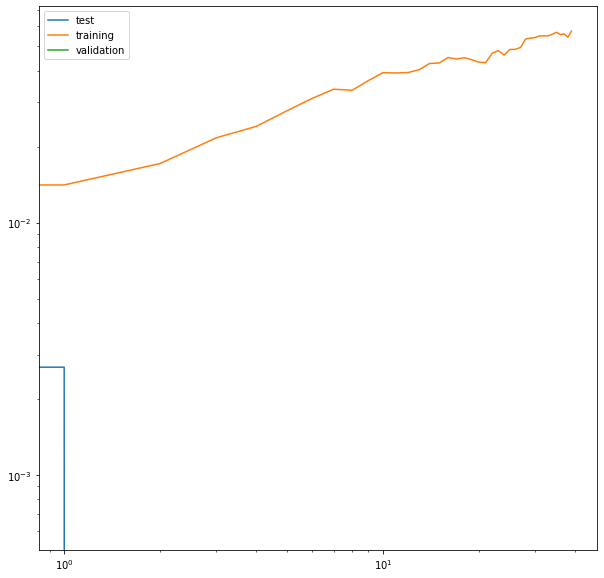

In [140]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
plt.plot(trainer.score_test, label="test")
plt.plot(trainer.score_training, label="training")
plt.plot(trainer.score_validation, label="validation")
plt.legend()
#plt.ylim([-1,1])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

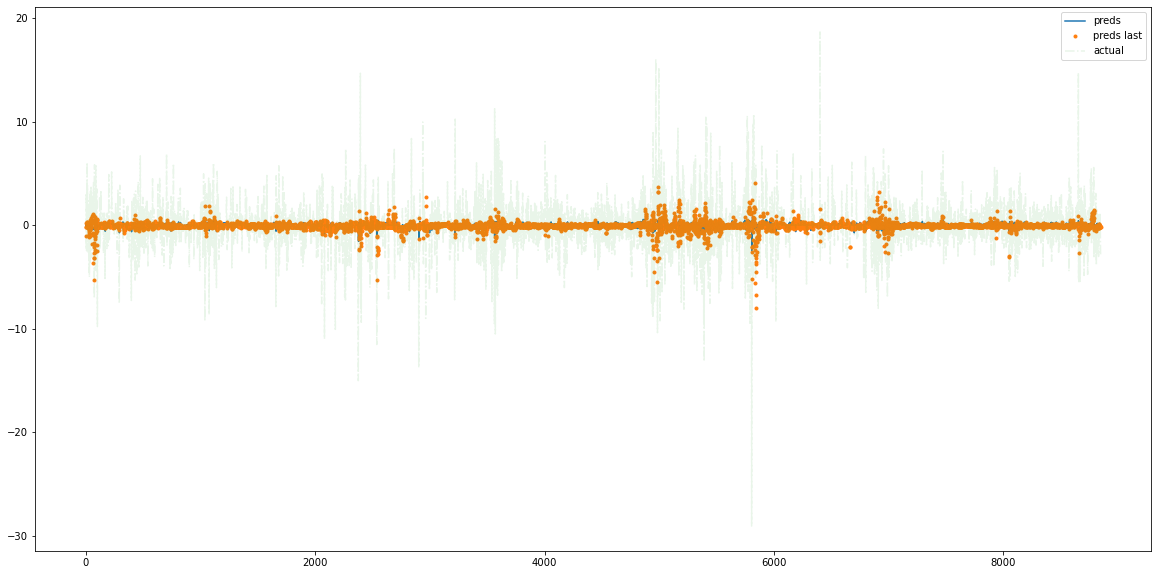

In [142]:
plt.figure(figsize=(20,10))
plt.plot(trainer.best_model.predict(df_validation[columns_features]), label="preds")
plt.plot(trainer.model.predict(df_validation[columns_features]), ".",label="preds last", alpha=1)
plt.plot(df_validation[columns_target].values, "-.", label="actual", alpha=0.1)
plt.legend()
plt.show()

In [1]:
from src.modules.paths import get_project_root
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [6]:
df_training_init.shape

(166939, 142)

In [38]:
df_training_init, df_validation, df_validation_unseen = load_training_and_validation()
df_training = df_training_init.sample(160000)

In [ ]:
#df_ada = pd.read_csv(get_project_root() / "data" / "training" / "adaeur_training.csv")
#df_xlm = pd.read_csv(get_project_root() / "data" / "training" / "xlmeur_training.csv")
#df_xlm = pd.read_csv(get_project_root() / "data" / "training" / "xlmeur_training.csv")
#df_validation_xlm_unseen = df_xlm[df_xlm.type=="validation_unseen"]
#df_validation_ada_unseen = df_ada[df_ada.type=="validation_unseen"]
#df_validation_xlm = df_xlm[df_xlm.type=="validation"]
#df_validation_ada = df_ada[df_ada.type=="validation"]
#df_training = df_xlm[df_xlm.type=="training"]

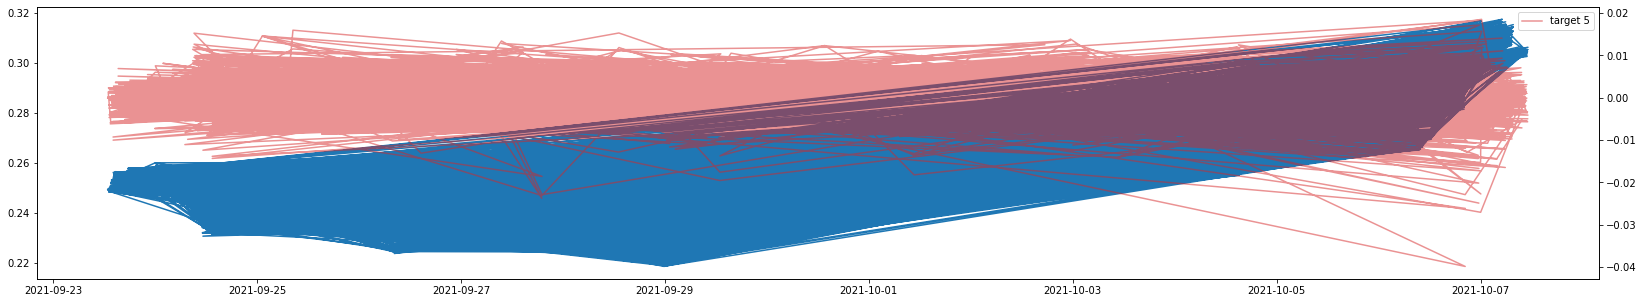

In [7]:
fig, ax1 = plt.subplots(figsize=(28,5))
ax1.plot(df_training[df_training.pair_name=="xlmeur"].date, df_training[df_training.pair_name=="xlmeur"].close, label="close", color="tab:blue")
ax2 = ax1.twinx()
ax2.plot(df_training[df_training.pair_name=="xlmeur"].date, df_training[df_training.pair_name=="xlmeur"].target_5, label="target 5", color="tab:red", alpha=0.5)
plt.legend()
plt.show()
#df_training[df_training.pair_name=="xlmeur"].reset_index().target_5.plot()

In [4]:
columns_features_init = [col for col in df_training.columns if col.startswith("feature_domain")]
columns_target = [col for col in df_training.columns if col.startswith("target")]
columns_target = ["target_5"]

In [13]:
# Feature selection
#mut = mutual_info_regression(df_training[columns_features_init], df_training[columns_target].values.ravel(), random_state=1)

In [ ]:
#columns_features

In [5]:
#indexes = mut.argsort()[-20:][::-1]
#columns_features = [columns_features_init[i] for i in indexes]
columns_features = columns_features_init

In [12]:
#columns_features_init

# RF

In [83]:
rfr = RandomForestRegressor(n_estimators=500, max_depth=50, random_state=1, n_jobs=8)

In [84]:
rfr.fit(df_training[columns_features], df_training[columns_target].values.ravel())

RandomForestRegressor(max_depth=50, n_estimators=500, n_jobs=8, random_state=1)

In [104]:
score_predictions(rfr, df_training, df_validation, df_validation_unseen, columns_features, columns_target)

training :  0.8641329753838339
val :  -0.025988773879630056
val  unseen:  -0.0600305069803706


# NN

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

In [5]:
nn = MLPRegressor(hidden_layer_sizes=(20,20,20), warm_start=True, random_state=1, max_iter=200, verbose=False, tol=1e-6)
pipe = Pipeline([("std_scaler", StandardScaler()),
                ("nn", nn)]
               )

In [6]:
pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('nn',
                 MLPRegressor(hidden_layer_sizes=(20, 20, 20), random_state=1,
                              tol=1e-06, warm_start=True))])

In [40]:
list_score = []
v_u_s_init = 0

In [41]:

for it in range(500):
    pipe.fit(df_training[columns_features],df_training[columns_target].values.ravel())
    if it%10 ==0:
        t_s, v_s, v_u_s = score_predictions(pipe, df_training, df_validation, df_validation_unseen, columns_features, columns_target)
        list_score.append([t_s, v_s, v_u_s])
        print(t_s, v_s, v_u_s)
        if v_u_s > v_u_s_init:
            print("Yieh, saving model")
            pickle.dump(pipe, open("NN_20_20_20_20.pickle", 'wb'))
            v_u_s_init = v_u_s

-0.0033221562725340714 -0.01493007638655075 -0.02062603712747113
0.0035520938450881445 -0.003591359520947357 -0.01912561000336299
0.0016065383068815109 -0.003715534683620625 -0.010808555907077189
-0.014534720167572734 -0.01748051763168834 -0.021206311967102653
-0.002969779399250916 -0.009359651144239978 -0.02027676614903884
-0.059270248969758965 -0.07066087877625016 -0.07535357736619819
-0.0417829964637475 -0.05186689468633521 -0.0589578153448711
-0.010427656450016087 -0.01700647614383355 -0.027489888829054454
0.002018683234431773 -0.0022209907173489363 -0.011095713252265549
0.0020578603462656497 -0.0020163233236756284 -0.010053606012204286
0.0018188905181951709 -0.0023671552315254196 -0.010013210772743086
0.0013885374669179162 -0.0028043998337268228 -0.010241127091185964
0.000852641136632748 -0.00315458145249492 -0.010300085210404708
0.0004112367009053708 -0.003201996882736813 -0.009770751362596863
-0.0005142595418730078 -0.004300393651441192 -0.010504315196167235
-0.00119164510129077

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.001253662555638968 -0.00047637997046767744 -1.1813945587357821e-05
-0.01498452472050582 -0.01898169549109463 -0.020101289568312586


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-0.001175785077033531 -0.002367560701931559 -0.003683785369822168


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.0017239235577870549 -0.0007844598014201676 -8.212090022485796e-05


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-4.48392471241732e-06 -0.00014016873211319947 -0.0007395225507826897


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.0030835181528381383 -0.004919212930974304 -0.006438113941905632


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.0032753063162205276 -0.005163451593100055 -0.006691714017655226


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.002030255555876437 -0.0035459406965587803 -0.004984773028874789


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-0.017520289929006783 -0.014370720048935137 -0.008584389961601824


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.00023453017556707145 -0.0008683633058133022 -0.0018691860506878655


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

-0.0001822499117718479 -0.0007635903475073924 -0.0017276148394842483


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-

In [111]:
score_predictions(pipe, df_training, df_validation, df_validation_unseen, columns_features, columns_target)

training :  -95.82969423187696
val :  -125.56888086206742
val  unseen:  -43.144519332507585


# xgboost

In [16]:
from xgboost import XGBRegressor

In [18]:
target=columns_target

In [109]:
#3 0.01 6000 subsample=0.8 0.001 target 5

model = XGBRegressor(
    max_depth=3,
    learning_rate=0.01,
    n_estimators=500,
    n_jobs=4,
    subsample=0.8,
    colsample_bytree=0.1,
    verbosity=1,
    #gamma=0.3
)

In [35]:
max_depths = [20]
n_estimators = [5000]
gammas = [0.002]
learning_rates = [0.0075]

list_params = [(max_depth, n_estimator, gamma, learning_rate) for learning_rate in learning_rates for gamma in gammas for max_depth in max_depths for n_estimator in n_estimators ]

In [36]:
list_score ={}
df_training_sample = df_training.sample(100000)
for max_depth, n_estimator, gamma, learning_rate in list_params:
    score_training, score_validation, score_validation_unseen = trainer(
        df_training_sample=df_training_sample,
        df_validation=df_validation,
        df_validation_unseen=df_validation_unseen,
        max_depth=max_depth,
        n_estimator=n_estimator,
        gamma=gamma,
        learning_rate=learning_rate
    )
    print(max_depth,n_estimator,gamma,learning_rate, ":", score_training, score_validation, score_validation_unseen )
    list_score["_".join([str(max_depth),str(n_estimator), str(gamma), str(learning_rate)])] = (score_training, score_validation, score_validation_unseen)
    

KeyboardInterrupt: 

In [22]:
def trainer(df_training_sample, df_validation, df_validation_unseen, max_depth, n_estimator, gamma, learning_rate):
    model = XGBRegressor(
    max_depth=max_depth,
    learning_rate=learning_rate,
    n_estimators=n_estimator,
    n_jobs=4,
    subsample=0.7,
    colsample_bytree=0.1,
    verbosity=1,
    gamma=gamma
    )
    #print(model)
    model.fit(df_training_sample[columns_features], df_training_sample[target].values.ravel())
    score_training = model.score(df_training_sample[columns_features], df_training_sample[target])
    score_validation= model.score(df_validation[columns_features], df_validation[target])
    score_validation_unseen = model.score(df_validation_unseen[columns_features], df_validation_unseen[target])
    print(model.predict(df_validation_unseen[columns_features]).mean())
    print(model.predict(df_validation_unseen[columns_features]).max())
    #model.predict(df_validation_unseen[columns_features]).plot()
    return score_training, score_validation, score_validation_unseen

In [125]:
for target in ["target_10"]:
    print(target)
    model = XGBRegressor(
    max_depth=10,
    learning_rate=0.0075,
    n_estimators=10000,
    n_jobs=4,
    subsample=0.7,
    colsample_bytree=0.1,
    verbosity=1,
    gamma=0.3
)
    model.fit(df_training[columns_features], df_training[target].values.ravel())
    print("training : ",model.score(df_training[columns_features], df_training[target]))
    print("val : ",model.score(df_validation[columns_features], df_validation[target]))
    print("val  unseen: ",model.score(df_validation_unseen[columns_features], df_validation_unseen[target]))

target_10
training :  -1.476019306778653e-11
val :  -0.006685409306543599
val  unseen:  -0.006610738202916355


In [114]:
#print("training : ",model.score(df_training[columns_features], df_training[columns_target]))
#print("val : ",model.score(df_validation[columns_features], df_validation[columns_target]))
#print("val  unseen: ",model.score(df_validation_unseen[columns_features], df_validation_unseen[columns_target]))

ValueError: y_true and y_pred have different number of output (8!=1)

In [317]:
def plot(df):
    plt.figure(figsize=(20,10))
    plt.plot(df[df.type=="training"].index,df[df.type=="training"][columns_target])
    plt.plot(df[df.type=="validation"].index,df[df.type=="validation"][columns_target])
    plt.plot(df[df.type=="validation_unseen"].index,df[df.type=="validation_unseen"][columns_target])
    plt.show()

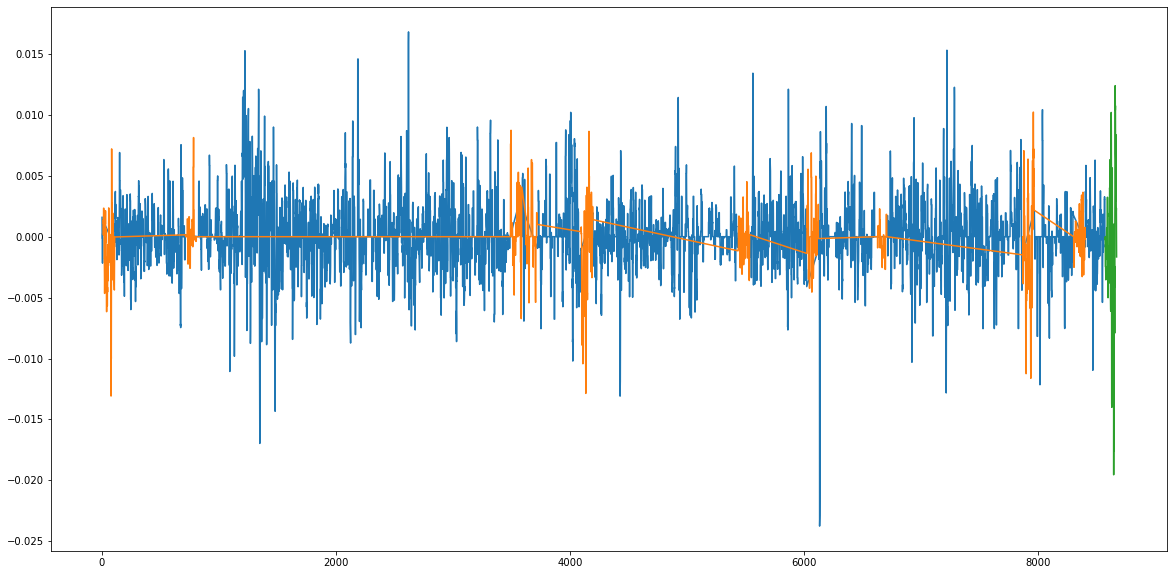

In [318]:
plot(df_xlm)

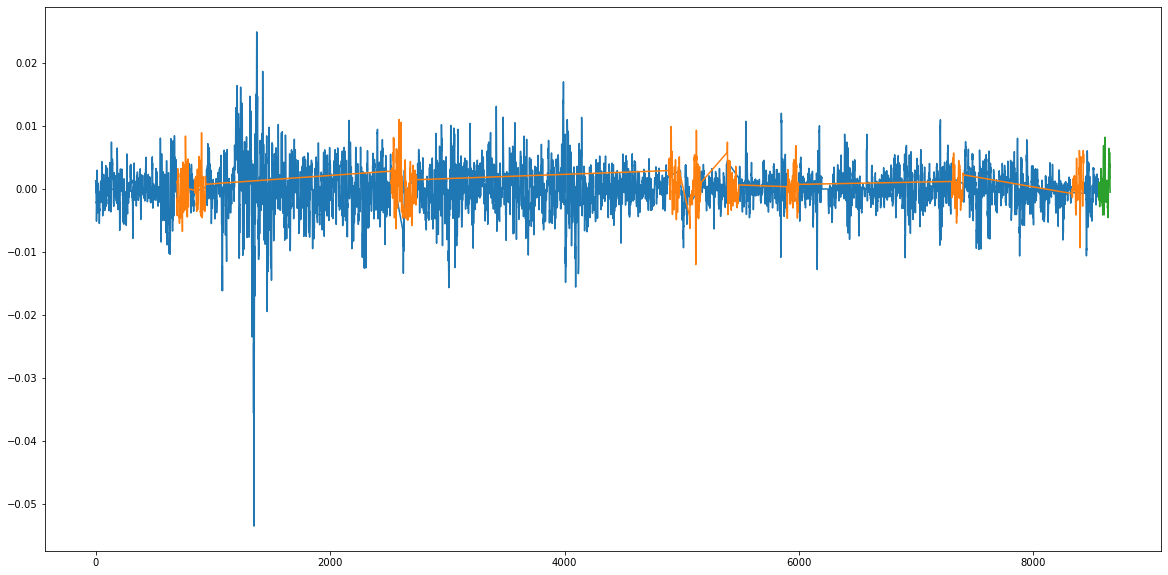

In [319]:
plot(df_ada)

In [30]:
y_pred = pipe.predict(df_validation_unseen[columns_features] )
y_true = df_validation_unseen[columns_target]

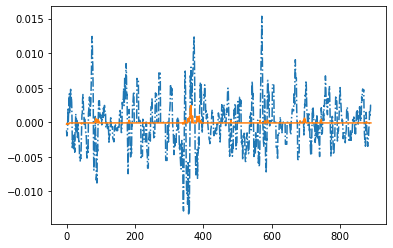

In [31]:
plt.plot(y_true.values, "-.")
plt.plot(y_pred)

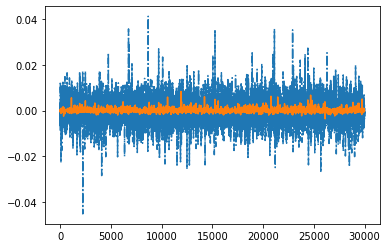

In [32]:
y_pred = pipe.predict(df_training[columns_features] )
y_true = df_training[columns_target]
plt.plot(y_true.values, "-.")
plt.plot(y_pred)